# Работа с картой
https://habr.com/ru/post/338440/  
http://overpass-turbo.eu/  
```Js
[out:json];
// Сохранить область в переменную `a`
area["name"="Липецк"]->.a;
// Скачать все дороги внутри a у которых аттрибут `highway == cycleway`
way["highway"~"primary|primary_link|secondary|secondary_link|living_street|service|service_link|residential|residential_link"](area.a);

//нужны
//primary (primary_link) - главные дороги
//secondary (secondary_link) - жёлтые дороги
//living_street
//service (service_link) - все дороги во дворах
//residential (residential_link) - тоже дороги

//спорный вопрос
//unclassified
//trunk (trunk_link) - шоссе за городом


//не нужны
//motorway (motorway_link)
//pedestrian - пешеходные дороги
//road - дороги в жопе мира



// и объединить дороги с узлами графа (узлы содержат геопозицию)
//node(w);

// Наконец, вернуть результаты
out meta;
```

In [154]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

plt.style.use('dark_background')

## Тута создаём массивы с вершинами и их типами
Дорога жёлтая, дорога белая, район дороги (порядковая нумерация).

In [155]:
'''
p_type[:, 0] - 1 - если дорога жёлтая, 0 - если серая
p_type[:, 1] - номер района. (-1) - если не определен
'''

vertics = pd.read_json('vertics')
points = np.zeros((vertics.shape[0], 2), dtype=float)
p_type = np.zeros((vertics.shape[0], 2), dtype=int)
p_id = []
for i in range(vertics.shape[0]):
    points[i, 0] = vertics['coordinates'][i][0]
    points[i, 1] = vertics['coordinates'][i][1]
    p_type[i, 0] = 1 if vertics['is_big_node'][i] else 0
    p_type[i, 1] = -1
    p_id.append(vertics['_id'][i]['$oid'])
    


In [156]:
vertics

,_id,coordinates,is_big_node
0,{'$oid': '617382efacd9177a56bf14e8'},"[52.609432, 39.5811687]",False
1,{'$oid': '617382f0acd9177a56bf14e9'},"[52.6095023, 39.5841104]",False
2,{'$oid': '617382f0acd9177a56bf14ea'},"[52.6174038, 39.5959138]",False
3,{'$oid': '617382f0acd9177a56bf14eb'},"[52.6189303, 39.5955814]",False
4,{'$oid': '617382f0acd9177a56bf14ec'},"[52.620007, 39.4971189]",False
...,...,...,...
16580,{'$oid': '6173b0edb223b19fde8ee6b8'},"[52.5456155, 39.752655]",True
16581,{'$oid': '6173b0edb223b19fde8ee6b9'},"[52.5451947, 39.7536931]",True
16582,{'$oid': '6173b0edb223b19fde8ee6ba'},"[52.5462928, 39.7509371]",True
16583,{'$oid': '6173b0edb223b19fde8ee6bb'},"[52.5462404, 39.751068]",True


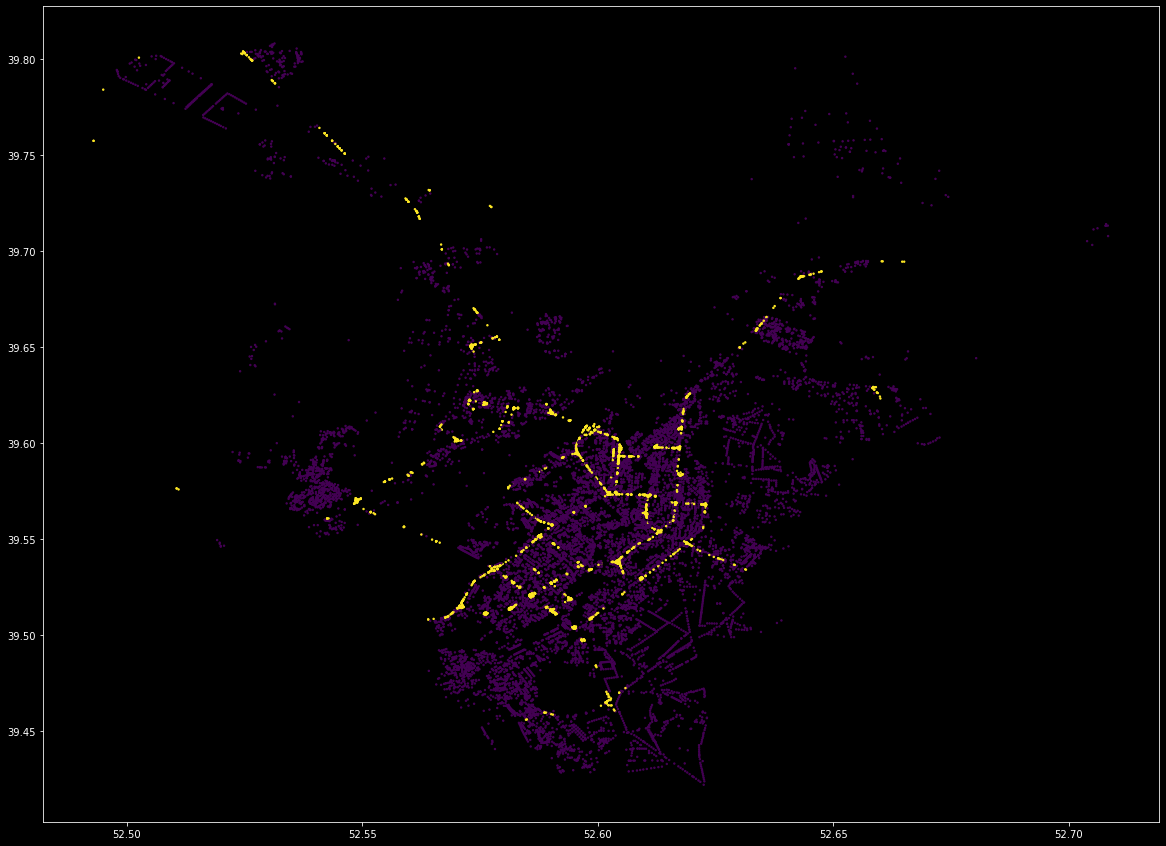

In [157]:
fig = plt.gcf()
fig.set_size_inches(20, 15)

plt.scatter(points[:, 0], points[:, 1], s=2, c=p_type[:,0])

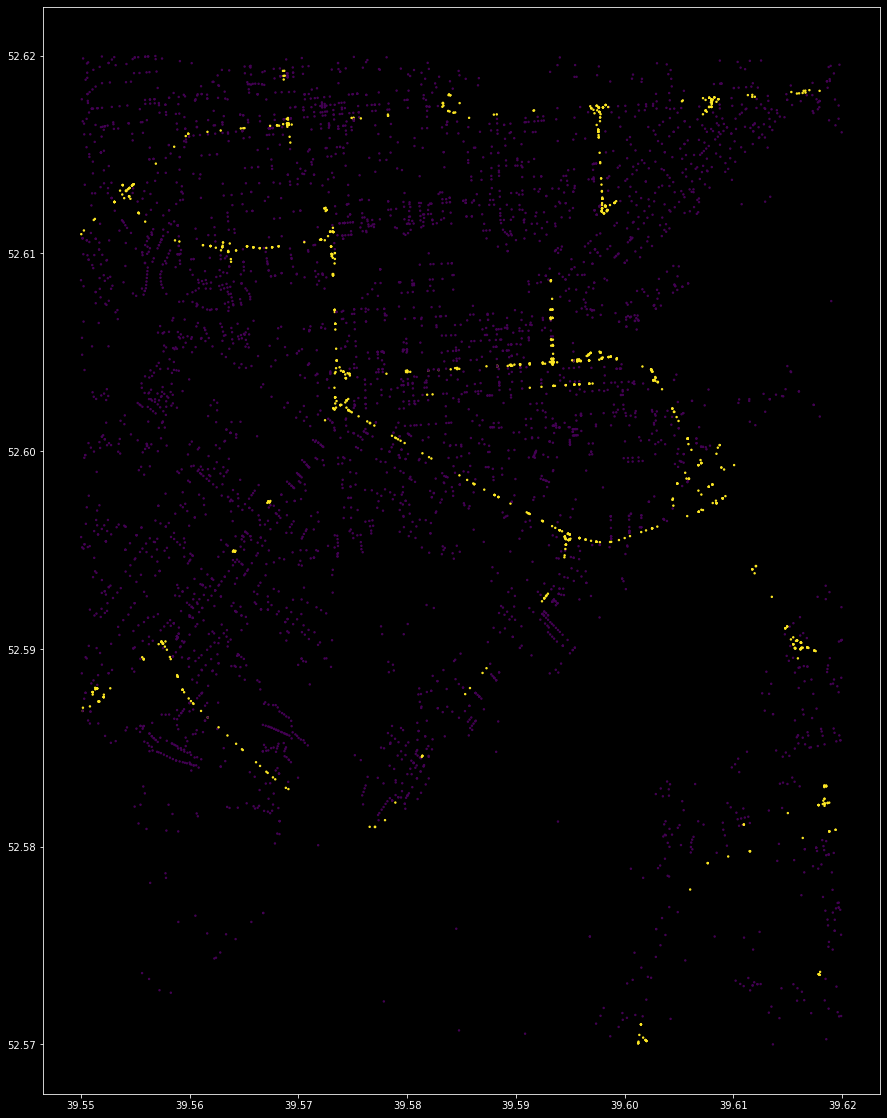

In [158]:
x_n = []
y_n = []
t_n = []
for i in range(points.shape[0]):
    if 52.57 < points[i, 0] and points[i, 0] < 52.62 and 39.55 < points[i,1] and points[i, 1] < 39.62:
        x_n.append(points[i, 1])
        y_n.append(points[i, 0])
        t_n.append(p_type[i, 0])

# for i in range(len(y_n)):
#     y_n[i] *= -1
#     x_n[i] *= -1

points_n = np.zeros((len(x_n), 2), dtype=float)
p_type_n = np.zeros(len(x_n), dtype=int)

for i in range(len(x_n)):
    points_n[i, 0] = x_n[i]
    points_n[i, 1] = y_n[i]
    p_type_n[i] = t_n[i]

fig = plt.gcf()
fig.set_size_inches(15, 20)

plt.scatter(points_n[:, 0], points_n[:, 1], s=2, c=p_type_n)

## Тута создаём массивы с вершинами дорог 
Дороги соединяют две точки по ПДД. Разделяем их за нехваткой времени.

In [159]:
roads = pd.read_json('road')
r_in = []
r_out = []
for i in range(roads.shape[0]):
    r_in.append(roads['in_vertics'][i]['vertics_id'])
    r_out.append(roads['out_vertics'][i]['vertics_id'])

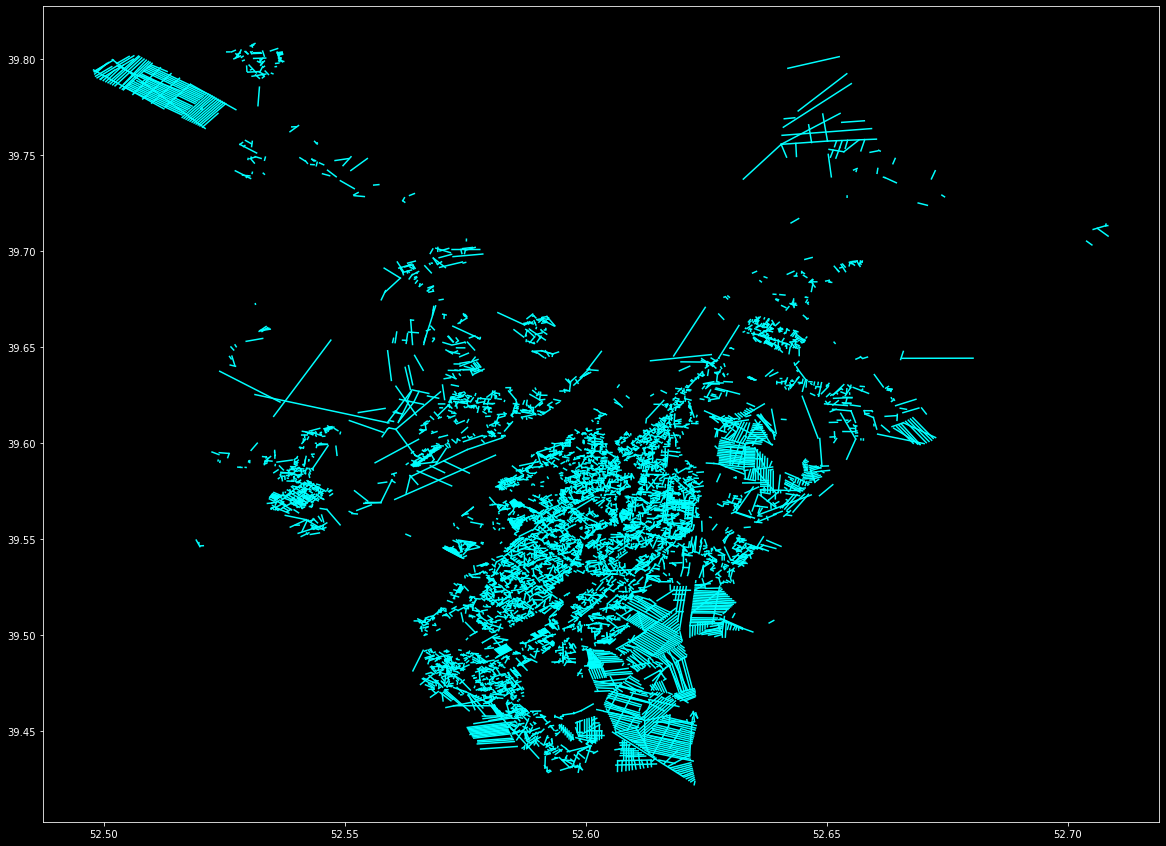

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

for i in range(len(r_in)):
    x1, y1 = points[p_id.index(r_in[i])]
    x2, y2 = points[p_id.index(r_out[i])]
    plt.plot((x1, x2), (y1, y2), color='cyan')


## Далее реализуем bfs и распределяем точки по районам

In [161]:
def bfs(v_id, cur_id, p_type, p_id, r_in, r_out):
    _in = 0
    _out = 0

    p_type[p_id.index(v_id), 1] = cur_id
    
    while (True):
        if v_id in r_in[_in:]:
            _in = r_in[_in:].index(v_id) + 1
            v_id_n = r_out[_in - 1]
            if p_type[p_id.index(v_id_n)][0] != 1 and p_type[p_id.index(v_id_n)][1] == -1:
                bfs(v_id_n, cur_id, p_type, p_id, r_in, r_out)
                continue
        if v_id in r_out[_out:]:
            _out = r_out[_out:].index(v_id) + 1
            v_id_n = r_in[_out - 1]
            if p_type[p_id.index(v_id_n)][0] != 1 and p_type[p_id.index(v_id_n)][1] == -1:
                bfs(v_id_n, cur_id, p_type, p_id, r_in, r_out)
                continue
        break

In [162]:
_id = 0     # id района, к которому определяем дорогу
itero = 0

for v in r_in:
    p_info = p_type[p_id.index(v)]
    
    # если дорога не главная
    # если дорога не определена к району
    if p_info[0] != 1 and p_info[1] == -1:
        bfs(v, _id, p_type, p_id, r_in, r_out)
        _id += 1
        
# for v in r_out:
#     p_info = p_type[p_id.index(v)]
    
#     # если дорога не главная
#     # если дорога не определена к району
#     if p_info[0] != 1 and p_info[1] == -1:
#         bfs(p_id.index(v), _id, p_type, p_id, r_in, r_out)
#         _id += 1

print(len(r_in), _id)

7119 5846


In [163]:
cnt = 0
for v in p_type:
    cnt += 1 if v[1] != -1 else 0
_id

5846

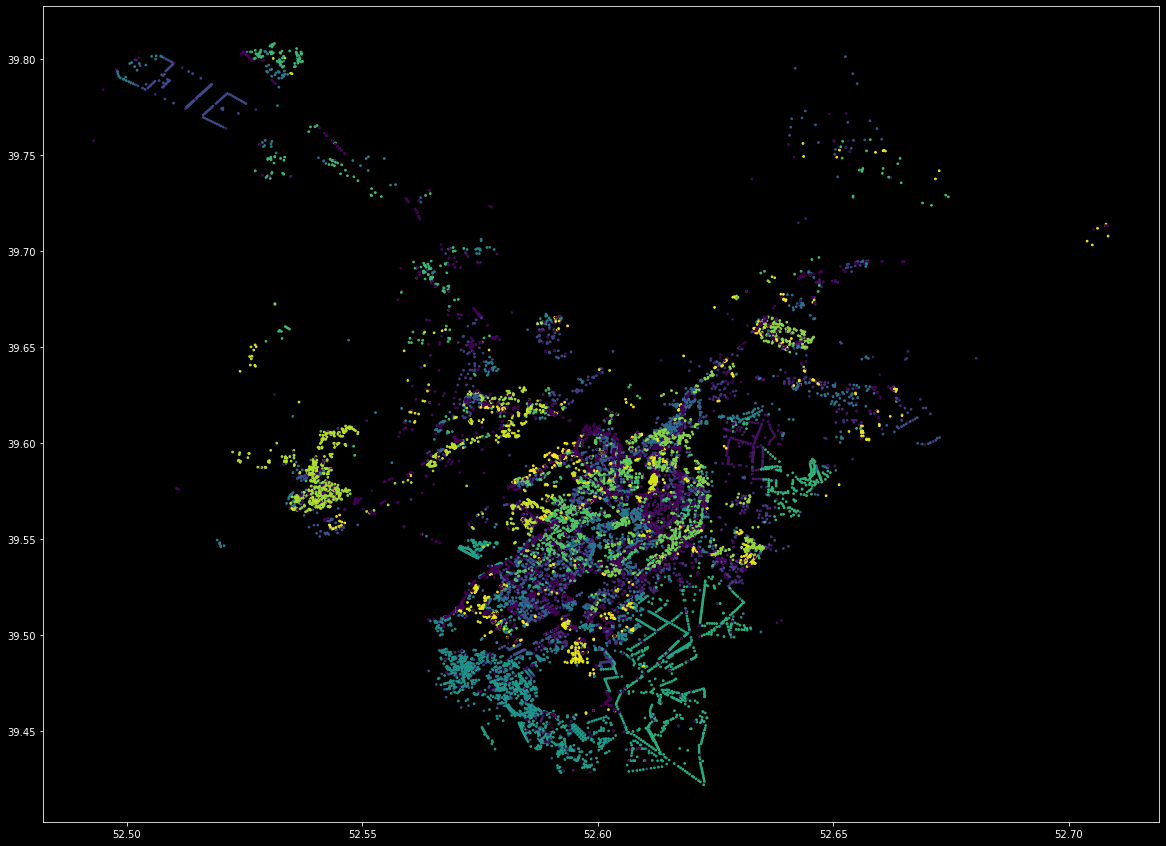

In [164]:
fig = plt.gcf()
fig.set_size_inches(20, 15)

plt.scatter(points[:, 0], points[:, 1], s=3, c=p_type[:,1])

In [165]:
with open('points.geojson') as f:
    res = json.load(f)

# node_id[:, 0] - id
# node_id[:, 1] - тип точки (жёлтая[0], серая[1], жёлтая+серая[2])
# node_id[:, 2] - номер района
node_id = np.zeros((len(res['features']), 3), dtype='int64')
node_ax = np.zeros((len(res['features']), 2), dtype=float)

for i in tqdm(range(len(res['features']))):
    node_id[i][0] = int(res['features'][i]['id'][5:])
    node_id[i][1] = (-5)
    node_id[i][2] = (-5)
    node_ax[i][0] = float(res['features'][i]['geometry']['coordinates'][0])
    node_ax[i][1] = float(res['features'][i]['geometry']['coordinates'][1])

100%|██████████| 42483/42483 [00:00<00:00, 345911.49it/s]


In [166]:
df = pd.read_json('Trulala')

# roads[i][0] - id
# roads[i][1] - type
# roads[i][2] - in
# roads[i][3] - out
roads = np.zeros((df.shape[0], 4), dtype='int64')

for i in tqdm(range(df.shape[0])):
    if df['nodes'][i][0] in node_id and df['nodes'][i][1] in node_id:
        roads[i][0] = df['r_id'][i]
        roads[i][1] = (-1) if df['type'][i] == 0 else (-2)
        roads[i][2] = df['nodes'][i][0]
        roads[i][3] = df['nodes'][i][1]

100%|██████████| 46446/46446 [00:06<00:00, 6777.51it/s]


In [167]:
for i in tqdm(range(node_id.shape[0])):
    sock = []
    
    kuda = np.where(roads[:, 2] == node_id[i][0])
    for ver in kuda[0]:
        if roads[ver, 1] not in sock:
            sock.append(roads[ver, 1])
            
    kuda = np.where(roads[:, 3] == node_id[i][0])
    for ver in kuda[0]:
        if roads[ver, 1] not in sock:
            sock.append(roads[ver, 1])
            
    if (-1) in sock and (-2) in sock:
        node_id[i][1] = 2
    elif (-2) in sock:
        node_id[i][1] = 1
    else:
        node_id[i][1] = 0
        node_id[i][2] = (-1)

100%|██████████| 42483/42483 [00:05<00:00, 7266.58it/s]


In [181]:
def bfs(v_id, cur_id, node_id, roads):
    
    it = np.where(node_id[:, 0] == v_id)[0][0]
    
    node_id[it, 2] = cur_id
    
    if v_id in roads[:, 2]:
        # получаем номер каждой строчки, где упоминается данная вершина
        _in = np.where(roads[:, 2] == node_id[it, 0])[0]
        for ver in _in:
            new_id = roads[ver, 3]
            new_it = np.where(node_id[:, 0] == new_id)[0][0]
            if node_id[new_it, 1] == 1 and node_id[new_it, 2] == (-5):
                bfs(new_id, cur_id, node_id, roads)
            elif node_id[new_it, 1] == 2 and node_id[new_it, 2] == (-5):
                node_id[new_it, 2] == cur_id
    if v_id in roads[:, 3]:
        # получаем номер каждой строчки, где упоминается данная вершина
        _in = np.where(roads[:, 2] == node_id[it, 0])[0]
        for ver in _in:
            new_id = roads[ver, 2]
            new_it = np.where(node_id[:, 0] == new_id)[0][0]
            if node_id[new_it, 1] == 1 and node_id[new_it, 2] == (-5):
                bfs(new_id, cur_id, node_id, roads)
            elif node_id[new_it, 1] == 2 and node_id[new_it, 2] == (-5):
                node_id[new_it, 2] == cur_id


In [182]:
_id = 0     # id района, к которому определяем дорогу

for i in tqdm(range(node_id.shape[0])):
#     p_info = p_type[p_id.index(v)]

    # если дорога не главная
    # если дорога не определена к району
    if node_id[i, 1] == 2 and node_id[i, 2] == (-5):
        bfs(node_id[i, 0], _id, node_id, roads)
        _id += 1
    elif node_id[i, 1] == 0:
        node_id[i, 2] = -1
        
#     if p_info[0] != 1 and p_info[1] == -1:
#         bfs(v, _id, p_type, p_id, r_in, r_out)
#         _id += 1
        
# for v in r_out:
#     p_info = p_type[p_id.index(v)]
    
#     # если дорога не главная
#     # если дорога не определена к району
#     if p_info[0] != 1 and p_info[1] == -1:
#         bfs(p_id.index(v), _id, p_type, p_id, r_in, r_out)
#         _id += 1

# print(len(r_in), _id)

100%|██████████| 42483/42483 [00:00<00:00, 827147.60it/s]


In [183]:
typer = []
for i in range(node_id.shape[0]):
    if node_id[i,2] not in typer:
        typer.append(node_id[i, 2])
typer

[-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 165,
 29,
 30,
 364,
 31,
 32,
 33,
 34,
 35,
 242,
 36,
 37,
 38,
 40,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 405,
 47,
 48,
 60,
 56,
 49,
 97,
 50,
 64,
 199,
 70,
 51,
 160,
 52,
 53,
 365,
 54,
 55,
 427,
 57,
 58,
 84,
 59,
 61,
 62,
 63,
 508,
 65,
 66,
 113,
 67,
 406,
 102,
 68,
 69,
 71,
 72,
 73,
 91,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 120,
 381,
 83,
 85,
 152,
 86,
 87,
 335,
 88,
 366,
 411,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 247,
 480,
 114,
 115,
 116,
 117,
 118,
 119,
 121,
 483,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 440,
 142,
 143,
 144,
 145,
 146,
 147,
 208,
 148,
 149,
 150,
 151,
 408,
 153,
 154,
 155,
 156,
 157,
 158,
 331,
 159,
 161,
 162,
 163,
 

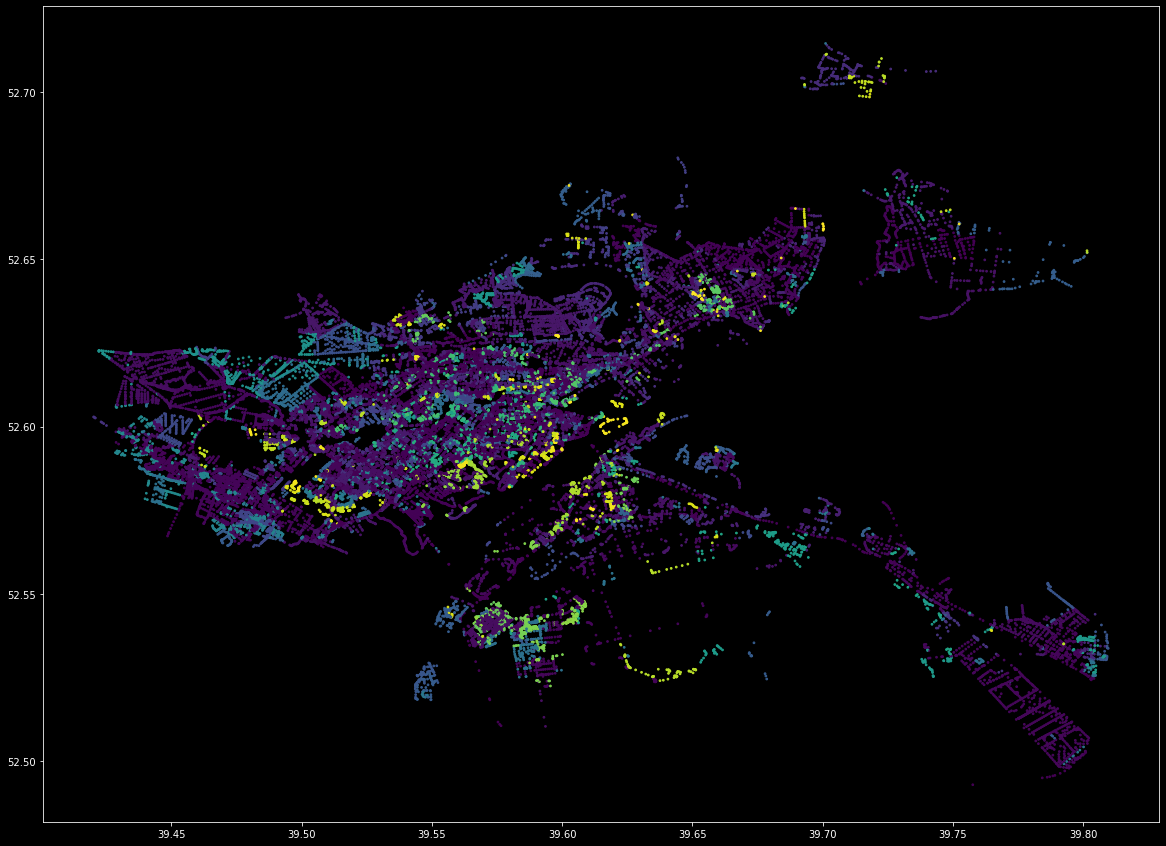

In [184]:
fig = plt.gcf()
fig.set_size_inches(20, 15)

plt.scatter(node_ax[:,0], node_ax[:,1], s=3, c=node_id[:,2])